In [1]:
import numpy as np
import pandas as pd
from math import gamma, exp

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def simple_plot(x, y):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    ax.grid()

### Nash cascade ans Instantaneous Unit Hydrograph

In [3]:
def calc_UIH(N, K, t_arr):
    steps_num = len(t_arr)
    Q_n_arr = np.empty(steps_num)
    for i in range(steps_num):
        t = t_arr[i]
        Q_n = (1./(gamma(N)*K))*((t/K)**(N-1))*exp(-t/K)
        Q_n_arr[i] = Q_n
    return Q_n_arr

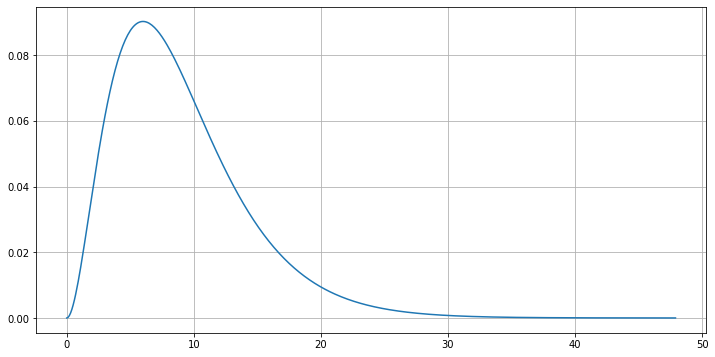

In [61]:
N_Reservoirs = 3
K = 3 # hours

dt = 0.1
time_steps = np.arange(0, 48, dt)
Q_n_arr = calc_UIH(N_Reservoirs, K, time_steps)

simple_plot(time_steps, Q_n_arr)

In [5]:
Input = 1 # mm/hour, because K has units hours
np.sum(Q_n_arr*dt)

0.9999999618734425

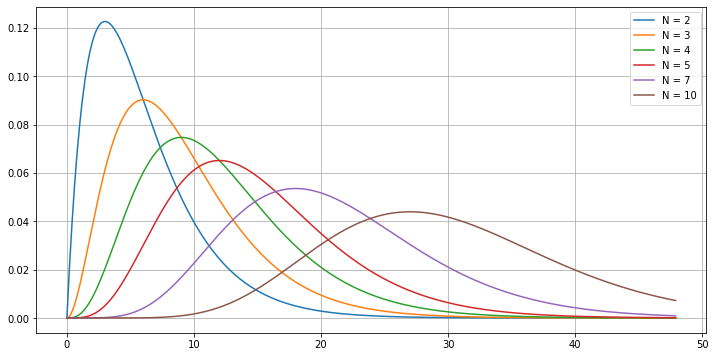

In [96]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

K = 3
dt = 0.1
time_steps = np.arange(0, 48, dt)
N_list = [2, 3, 4, 5, 7, 10]

for N in N_list:
    Q_n_arr = calc_UIH(N, K, time_steps)
    ax.plot(time_steps, Q_n_arr, label="N = " + str(N))   

legend = ax.legend()
ax.grid()

### Nash Cascade by sequential solution of linear reservoir ODE

In [107]:
class Reservoir():
    def __init__(self, name, K, S_0):
        self.name = name
        self.K = K
        self.S_0 = S_0 # initial storage at time t
        self.S_series = [] # list, container for Storage 
        self.Q_series = []
        
    def calc(self, P, Q_in, dt):
        I = P*dt + Q_in*dt # m3
        S_t = self.K * I + (self.S_0 - self.K * I) * exp(-dt/self.K)
        Q_out = (self.S_0 + I - S_t)/dt        
        self.S_0 = S_t
        self.S_series.append(S_t)
        self.Q_series.append(Q_out)

        return Q_out
        

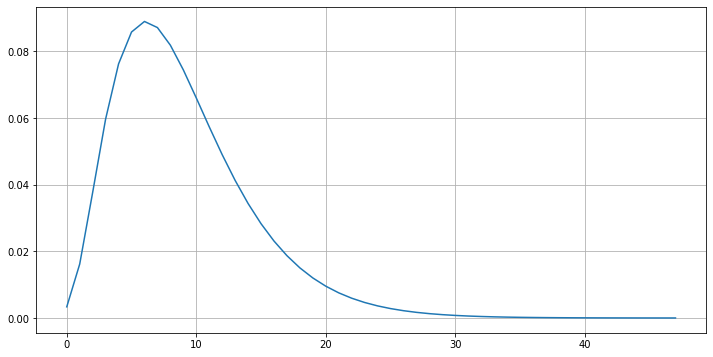

In [109]:
K = 3

reservoir_1 = Reservoir('R1', K, 0.0)
reservoir_2 = Reservoir('R2', K, 0.0)
reservoir_3 = Reservoir('R3', K, 0.0)

Reservoir_system = [reservoir_1, reservoir_2, reservoir_3]
dt = 1 # in hours or 6 min

time_steps = np.arange(0, 48, dt)
precipitation = np.zeros((len(time_steps), len(Reservoir_system)))
precipitation[0, 0] = 1.0 # mm/hour, because K has units hours

for time_step in range(len(time_steps)):
    Q_inflow = 0.0
    for index, reservoir in enumerate(Reservoir_system):
        P = precipitation[time_step, index]
        Q_outflow = reservoir.calc(P, Q_inflow, dt)
        Q_inflow = Q_outflow

simple_plot(time_steps, reservoir_3.Q_series)